## Abstract:
We will be examining the Instacart Database and trying to acquire some valuable business insights out of this. And we will be trying answer three different questions relating to this database. 

Question 1: What kind of products are purchased and reordered the most? The importance of this question is that we get a sense of what the most popular products are as well as maybe gaining an understanding of the multiple skews that are at play. Furthermore, we can decipher which departments are individually doing the best and we can opt to direct more support to flagging departments as a result. 

Question 2: What factors influence one's decision to reorder a good and can we make a model that accurately predicts whether a good will be reordered? This is important because with this knowledge we can prepare our inventory based on the likelihood  of a product being reordered in the future.Ideally we can shift our demand expectations to be closer in line with reality in general with the implementation of this. 


## O —  Obtaining our data: 
The Data was obtained from the Kaggle instacart dataset. 

## S — Scrubbing / Cleaning our data: 
The data is largely already pretty clean and required little modification before it was ready to use outside the box. 

## E — Exploring / Visualizing our data will allow us to find patterns and trends: 
Data Exploration Yielded many very interesting insights. We very quickly learn that a tremendous amount of instacart's sales are from organic products. Considering that organic products tend to be pricier than the inorganic variety. We may consider the organic product as a large driver of revenues. We also get to see which departments are performing best and worst. We discover that produce, dairy, snacks, and beverages make up the contents of over 50 percent of all instacart orders. Furthermore, we discover that people tend to reorder more on weekly or monthly intervals. 

## M — Modeling our data will give us our predictive power as a wizard: 
We produce a model that helps us predict whether a certain good will be reordered or not. This is really useful because it helps us anticipate future demand. Another model we make helps us see what customers similar to this customer purchase. This can assist us in determining what the complementary goods of a certain product is. If the demand of X and Y covary together we can see what a decrease in the price of X may increase the demand of Y as well. 

## N — Interpreting our data: 
Our model has a 71% accuracy at predicting whether someone will or will not reorder a product. Our recommendation system showed that whenever one is purchasing any kind of food product, it is good to suggest to the consumer to purchase fresh fruit. Additionally, we got insights about very specific goods like what to recommend when your customer purchases red wine (How about some white wine?)

First We will just import all the libraries and the tables we need. 

In [1]:
import numpy as np
import pandas as pd
from os import path as op

import gc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
import category_encoders as ce
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

import vtreat
import vtreat.util

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

plt.style.use('seaborn')
color = sns.color_palette()
%matplotlib inline

In [2]:
aisles=pd.read_csv('aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [3]:
len(aisles)

134

In [4]:
departments = pd.read_csv('departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
len(departments)

21

In [6]:
prev_orders = pd.read_csv('order_products__prior.csv')
print(len(prev_orders))
prev_orders.head()

32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
order_train = pd.read_csv('order_products__train.csv')
print(len(order_train))
order_train.head()

1384617


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [8]:
orders= pd.read_csv('orders.csv')
print(len(orders))
(orders.head())

3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
len(orders.order_id.unique())

3421083

In [10]:
prev_orders = prev_orders.sample(frac=0.1, random_state=1)

In [11]:
products = pd.read_csv('products.csv')
print(len(orders))
products.head()

3421083


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [12]:
prev_orders = pd.merge(prev_orders, products, on='product_id', how='left')

In [13]:
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1828726,11182,23,1,Baby Spinach,123,4
1,133158,17794,11,1,Carrots,83,4
2,1223705,30720,3,0,Sugar Snap Peas,83,4
3,2826286,19678,24,1,Organic Russet Potato,83,4
4,1883588,43713,9,0,Organic Creamy Peanut Butter,88,13


In [14]:
prev_orders = pd.merge(prev_orders, departments, on='department_id', how='left')
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,1828726,11182,23,1,Baby Spinach,123,4,produce
1,133158,17794,11,1,Carrots,83,4,produce
2,1223705,30720,3,0,Sugar Snap Peas,83,4,produce
3,2826286,19678,24,1,Organic Russet Potato,83,4,produce
4,1883588,43713,9,0,Organic Creamy Peanut Butter,88,13,pantry


In [15]:
prev_orders = pd.merge(prev_orders, aisles, on='aisle_id', how='left')
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,1828726,11182,23,1,Baby Spinach,123,4,produce,packaged vegetables fruits
1,133158,17794,11,1,Carrots,83,4,produce,fresh vegetables
2,1223705,30720,3,0,Sugar Snap Peas,83,4,produce,fresh vegetables
3,2826286,19678,24,1,Organic Russet Potato,83,4,produce,fresh vegetables
4,1883588,43713,9,0,Organic Creamy Peanut Butter,88,13,pantry,spreads


In [16]:
prev_orders['Organic'] = prev_orders['product_name'].str.contains('Organic').astype(int)

In [17]:
prev_orders = pd.merge(prev_orders, orders, on='order_id', how='left')

In [18]:
products = pd.read_csv('products.csv')
print(len(orders))
products.head()

3421083


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [19]:
products.describe()

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


Let's examine just how many items people tend to buy at one time to get our bearings. 

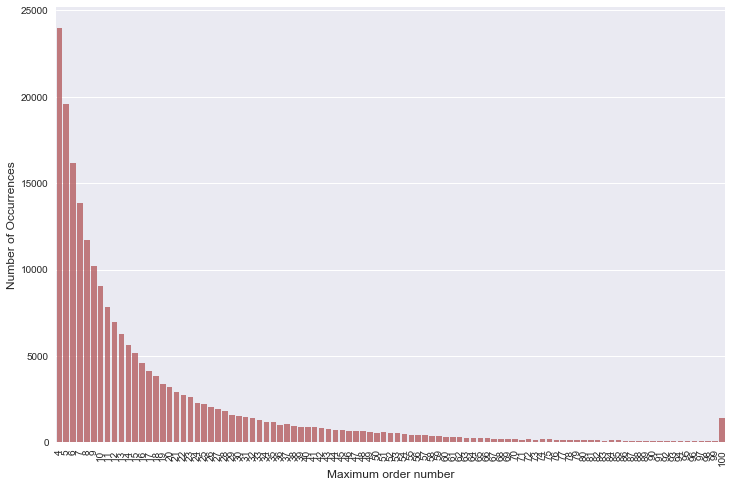

In [20]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Here, we obviously see that most orders have less than ten orders to them. Next, let's see which days of the week have the greatest sales. 

In [20]:
orders.order_dow=orders.order_dow.replace([0,1,2,3,4,5,6], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

In [21]:
prev_orders.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'department', 'aisle',
       'Organic', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

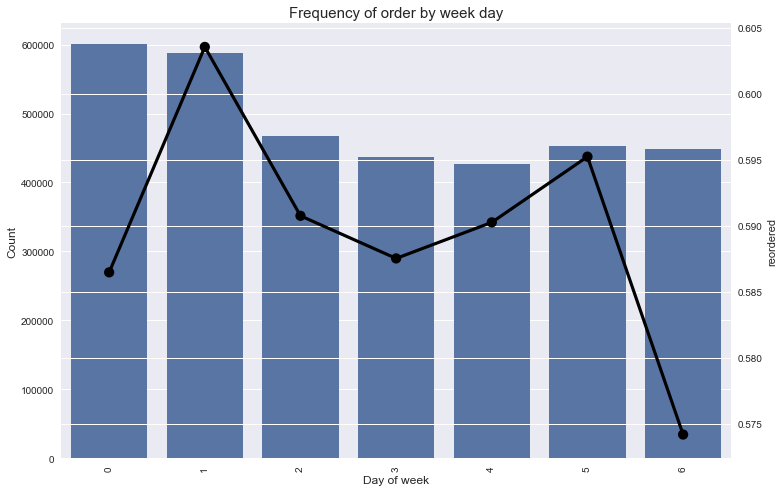

In [23]:
grouped_df = prev_orders.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
ordd= ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
ax = sns.countplot(x="order_dow", data=orders, color=color[0], order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Day of week', fontsize=12)
ax.set_xticklabels(ordd, rotation=90)
ax.set_title("Frequency of order by week day", fontsize=15)
ax2 = ax.twinx()
ax2=sns.pointplot(x='order_dow', y='reordered', data=grouped_df, 
                    color='black')
plt.show()

It looks like Sunday and Monday are the most common days where orders are made, though, it is only slightly higher. How about looking at the times where orders were made? 


In [22]:
orders.order_hour_of_day=orders.order_hour_of_day.replace([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'])

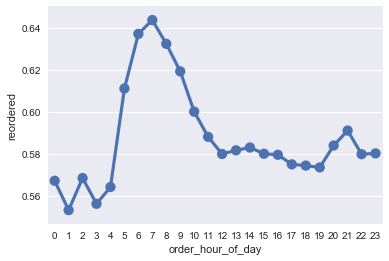

In [25]:
hours = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM']
grouped_df = prev_orders.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
ax2=sns.pointplot(x='order_hour_of_day', y='reordered', data=grouped_df)#,order =hours)

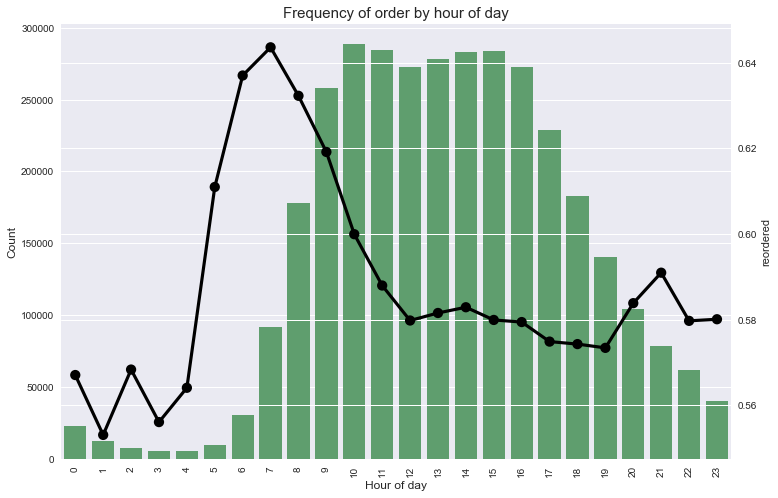

In [26]:
plt.figure(figsize=(12,8))
ax=sns.countplot(x="order_hour_of_day", data=orders, color=color[1], order = hours)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Hour of day', fontsize=12)
ax.set_xticklabels(hours,rotation=90)
ax.set_title("Frequency of order by hour of day", fontsize=15)
ax2 = ax.twinx()
ax2=sns.pointplot(x='order_hour_of_day', y='reordered', data=grouped_df, 
                    color='black')
plt.show()

Unsurprisingly, it doesn't seem like peopel are ordering many products in the dead of night and the fast majority appear to be made between 8 AM and 6 PM while the greatest proportion of reorders happen between 5 and 7 AM. Appears to share a similar distribution as the frequency by day of week. 

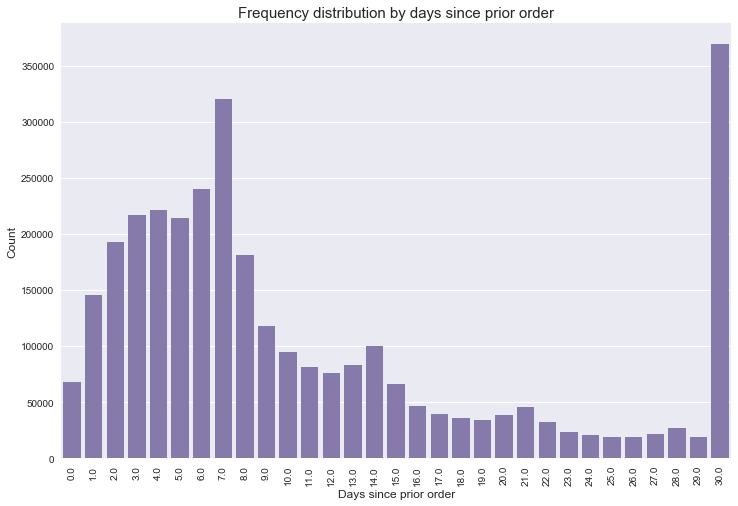

In [27]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

We see that most orders are made within 10 days with notable spikes at 7, 14, and 30 days. 

In [28]:
prev_orders.reordered.sum() / prev_orders.shape[0]

0.5899935531589984

58% of users order more than once 

In [29]:
order_train.reordered.sum() / order_train.shape[0]


0.5985944127509629

In [30]:
grouped_df = prev_orders.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

E:\Conda2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


1    0.681603
0    0.318397
Name: reordered, dtype: float64

In [31]:
grouped_df = order_train.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

E:\Conda2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


1    0.93444
0    0.06556
Name: reordered, dtype: float64

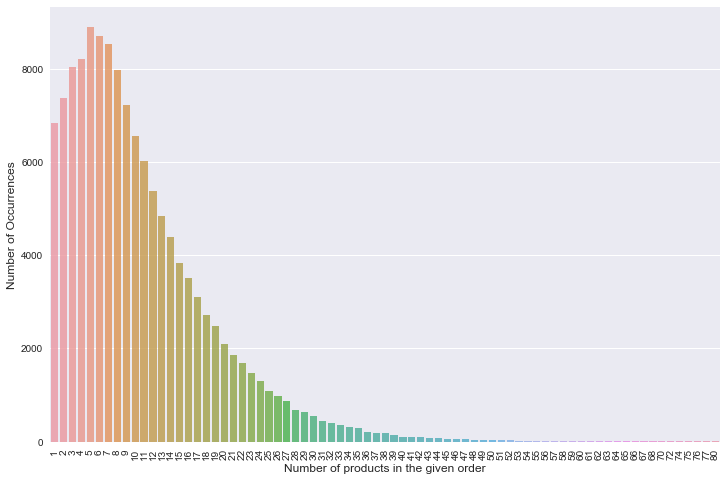

In [32]:
grouped_df = order_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Let's merge our dataframes so we can do some further exploration and analysis. 

In [23]:
prev_orders = prev_orders.sample(frac=0.1, random_state=1)

In [24]:
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,Organic,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
243639,1419982,8914,9,0,Chicken Breast,35,12,meat seafood,poultry counter,0,89138,prior,17,0,13,11.0
3214595,2125760,1244,38,1,Organic Orange Bell Pepper,83,4,produce,fresh vegetables,1,20554,prior,7,6,12,8.0
1876529,3368332,33401,9,0,Goat Cheese Crumbles,21,16,dairy eggs,packaged cheese,0,193112,prior,4,0,11,7.0
1092329,1991996,44142,13,0,Red Onion,83,4,produce,fresh vegetables,0,55248,prior,1,0,14,NaN
2698818,1238663,21174,6,0,I Heart Baby Kale,123,4,produce,packaged vegetables fruits,0,23643,prior,10,2,1,16.0


In [25]:
prev_orders.columns.tolist() #=cols

['order_id',
 'product_id',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle_id',
 'department_id',
 'department',
 'aisle',
 'Organic',
 'user_id',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']

In [36]:
cols=['order_id',
 'product_id',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle_id',
 'department_id',
 'department',
 'aisle',
 'Organic',
 'user_id',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order',
 'product_name',
 'aisle_id',
 'department_id']


In [37]:
# prev_orders = pd.merge(prev_orders, departments, on='department', how='left')
# prev_orders.head()

In [38]:
# prev_orders = pd.merge(prev_orders, aisles, on='aisle', how='left')
# prev_orders.head()

In [43]:
cnt_srs = prev_orders['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,4708
1,Bag of Organic Bananas,3826
2,Organic Strawberries,2635
3,Organic Baby Spinach,2491
4,Organic Hass Avocado,2191
5,Organic Avocado,1764
6,Large Lemon,1504
7,Organic Whole Milk,1456
8,Strawberries,1425
9,Limes,1393


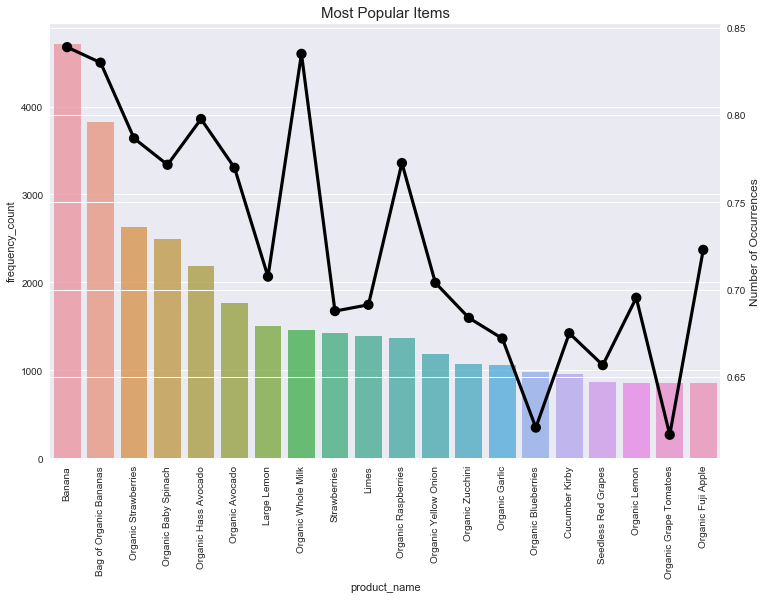

In [44]:
cnt_srs = prev_orders['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
grouped_df = prev_orders.groupby(["product_name"])["reordered"].aggregate("mean").reset_index()
g2=plt.figure(figsize=(12,8))
g2= sns.barplot(cnt_srs['product_name'].head(20), cnt_srs.frequency_count, alpha=0.8)
g22 = g2.twinx()
gg2=sns.pointplot(x='product_name', y='reordered', data=grouped_df, 
                    color='black', order=list(cnt_srs['product_name'].head(20)))
gg2.set_ylabel('Number of Occurrences', fontsize=12)
gg2.set_xlabel('Product', fontsize=12)
g2.set_xticklabels(g2.get_xticklabels(),rotation=90)
plt.title("Most Popular Items", fontsize=15)
plt.show()

Here we can see that bananas and other organic products represet a very large portion of the most ordered products. Let's look and see if our reordered products are the same. 

In [45]:
all_order_products = prev_orders.loc[prev_orders['reordered'] == 1, 'product_id']
products_dict = pd.read_csv('products.csv')
print('Top reordered products are...')
product_counts = all_order_products.value_counts().reset_index()
product_counts.columns = ['product_id','reordered']
product_counts['share'] = product_counts['reordered'] / product_counts['reordered'].sum()
product_counts = product_counts.merge(products_dict[['product_id','product_name']], how='left', on='product_id')
product_counts.head(10)

Top reordered products are...


,product_id,reordered,share,product_name
0,24852,3950,0.020640,Banana
1,13176,3176,0.016596,Bag of Organic Bananas
2,21137,2073,0.010832,Organic Strawberries
3,21903,1922,0.010043,Organic Baby Spinach
4,47209,1748,0.009134,Organic Hass Avocado
5,47766,1358,0.007096,Organic Avocado
6,27845,1216,0.006354,Organic Whole Milk
7,47626,1064,0.005560,Large Lemon
8,27966,1053,0.005502,Organic Raspberries
9,16797,980,0.005121,Strawberries


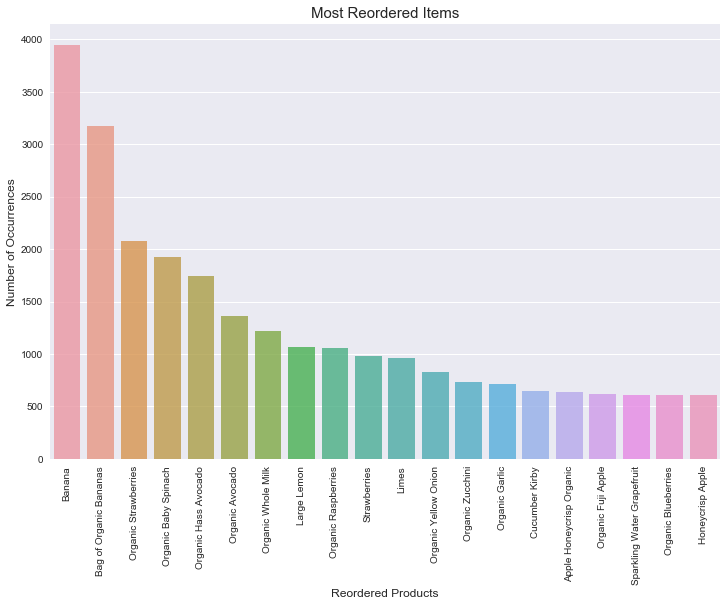

In [46]:
grouped_df = prev_orders.groupby(["product_name"])["reordered"].aggregate("mean").reset_index()
cnt_srs = product_counts['reordered'].head(20)
plt.figure(figsize=(12,8))
sns.barplot(product_counts['product_name'].head(20), cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Reordered Products', fontsize=12)
plt.title("Most Reordered Items", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

This is essentially the same list, just somewhat reordered. But let's look and see  what happens when we separate the organic and non organic products. 

In [67]:
cnt_srs = prev_orders['aisle'].value_counts().head(20).reset_index()
cnt_srs.columns = ['aisle', 'counts']
cnt_srs

,aisle,counts
0,fresh fruits,36371
1,fresh vegetables,34188
2,packaged vegetables fruits,17717
3,yogurt,14732
4,packaged cheese,9837
5,milk,9075
6,water seltzer sparkling water,8240
7,chips pretzels,7238
8,soy lactosefree,6426
9,refrigerated,5809


In [48]:
b=list(cnt_srs['aisle'].head(20))

In [64]:
grouped_df

,product_name,reordered
0,#2 Coffee Filters,0.125000
1,#4 Natural Brown Coffee Filters,0.500000
2,& Go! Hazelnut Spread + Pretzel Sticks,0.000000
3,(70% Juice!) Mountain Raspberry Juice Squeeze,0.000000
4,0 Calorie Fuji Apple Pear Water Beverage,0.666667
5,0 Calorie Strawberry Dragonfruit Water Beverage,1.000000
6,0% Fat Black Cherry Greek Yogurt y,1.000000
7,0% Fat Blueberry Greek Yogurt,0.200000
8,0% Fat Free Organic Milk,0.744186
9,0% Fat Greek Yogurt Black Cherry on the Bottom,0.000000


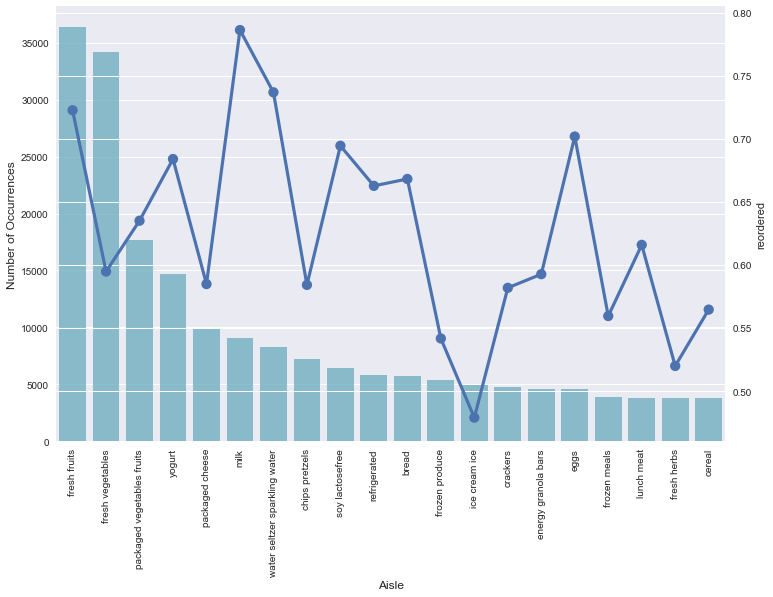

In [74]:
cnt_srs = prev_orders['aisle'].value_counts().head(20).reset_index()
cnt_srs.columns = ['aisle', 'counts']
plt.figure(figsize=(12,8))
ax=sns.barplot(cnt_srs.aisle, cnt_srs.counts, alpha=0.8, color=color[5])
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Aisle', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax2=ax.twinx()
ax2= sns.pointplot(x='aisle', y='reordered', data=grouped_df ,order = cnt_srs['aisle'])
plt.show()

So It seems liek a very large proportion of ordered and reordered items are organic. It may be interesting to see if organic products are reordered at different rates. 

In [57]:
prev_orders['Organic'] = prev_orders['product_name'].str.contains('Organic').astype(int)

In [58]:
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,Organic,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
243639,1419982,8914,9,0,Chicken Breast,35,12,meat seafood,poultry counter,0,89138,prior,17,0,13,11.0
3214595,2125760,1244,38,1,Organic Orange Bell Pepper,83,4,produce,fresh vegetables,1,20554,prior,7,6,12,8.0
1876529,3368332,33401,9,0,Goat Cheese Crumbles,21,16,dairy eggs,packaged cheese,0,193112,prior,4,0,11,7.0
1092329,1991996,44142,13,0,Red Onion,83,4,produce,fresh vegetables,0,55248,prior,1,0,14,NaN
2698818,1238663,21174,6,0,I Heart Baby Kale,123,4,produce,packaged vegetables fruits,0,23643,prior,10,2,1,16.0


In [59]:
all_order_products_organic = prev_orders.loc[prev_orders['reordered'] == 1]
all_order_products_organic = all_order_products_organic.loc[all_order_products_organic['Organic']==1, 'product_id']

In [60]:
#all_order_products_organic = prev_orders.loc[prev_orders['reordered'] == 1, 'product_id']
#all_order_products_organic = prev_orders.loc[prev_orders['Organic'] == 1, 'product_id']
#all_order_products_organic = all_order_products_organic.loc[all_order_products_organic['Organic']==1]
products_dict = pd.read_csv('products.csv')
print('Top reordered organic products are...')
product_counts = all_order_products_organic.value_counts().reset_index()
product_counts.columns = ['product_id','reordered']
product_counts['share'] = product_counts['reordered'] / product_counts['reordered'].sum()
product_counts = product_counts.merge(products_dict[['product_id','product_name']], how='left', on='product_id')
product_counts.head(30)

Top reordered organic products are...


,product_id,reordered,share,product_name
0,13176,3176,0.048577,Bag of Organic Bananas
1,21137,2073,0.031706,Organic Strawberries
2,21903,1922,0.029397,Organic Baby Spinach
3,47209,1748,0.026736,Organic Hass Avocado
4,47766,1358,0.020771,Organic Avocado
5,27845,1216,0.018599,Organic Whole Milk
6,27966,1053,0.016106,Organic Raspberries
7,22935,832,0.012725,Organic Yellow Onion
8,45007,731,0.011181,Organic Zucchini
9,24964,715,0.010936,Organic Garlic


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

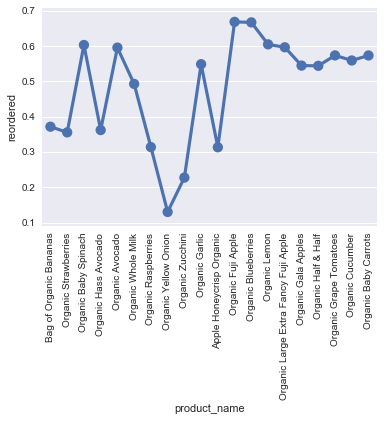

In [75]:
grouped_df = prev_orders.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
sns.pointplot(x=product_counts['product_name'].head(20), y=grouped_df.reordered)
plt.xticks(rotation='vertical')

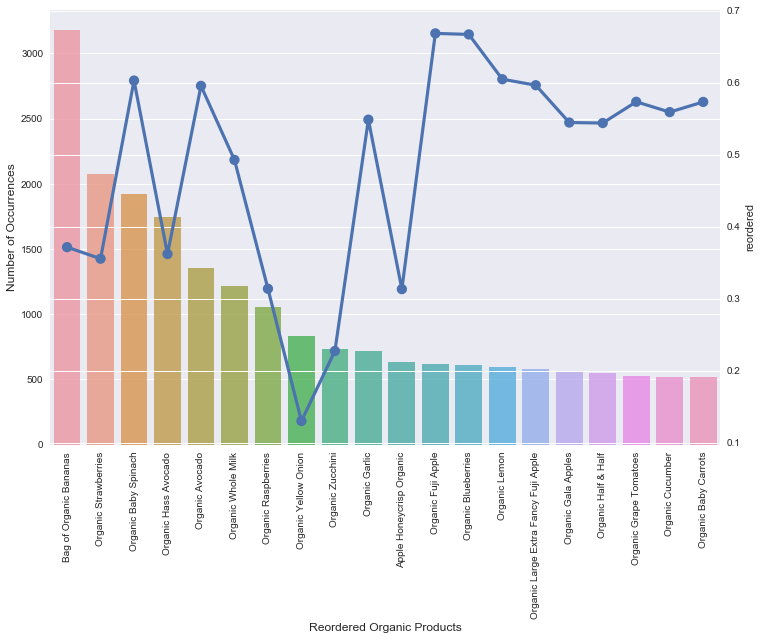

In [76]:
cnt_srs = product_counts['reordered'].head(20)
grouped_df = prev_orders.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
ax=sns.barplot(product_counts['product_name'].head(20), cnt_srs.values, alpha=0.8)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Reordered Organic Products', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax2= ax.twinx()
ax2= sns.pointplot(x=product_counts['product_name'].head(20), y=grouped_df.reordered)
plt.show()

In [77]:
all_order_products_organic = prev_orders#.loc[prev_orders['reordered'] == 1]
all_order_products_organic = all_order_products_organic.loc[all_order_products_organic['Organic']==0, 'product_id']
print('Top reordered non-organic products are...')
product_counts = all_order_products_organic.value_counts().reset_index()
product_counts.columns = ['product_id','reordered']
product_counts['share'] = product_counts['reordered'] / product_counts['reordered'].sum()
product_counts = product_counts.merge(products_dict[['product_id','product_name']], how='left', on='product_id')
product_counts.head(30)

Top reordered non-organic products are...


,product_id,reordered,share,product_name
0,24852,4708,0.021230,Banana
1,47626,1504,0.006782,Large Lemon
2,16797,1425,0.006426,Strawberries
3,26209,1393,0.006281,Limes
4,49683,957,0.004315,Cucumber Kirby
5,4920,871,0.003928,Seedless Red Grapes
6,45066,796,0.003589,Honeycrisp Apple
7,44632,775,0.003495,Sparkling Water Grapefruit
8,4605,746,0.003364,Yellow Onions
9,27104,743,0.003350,Fresh Cauliflower


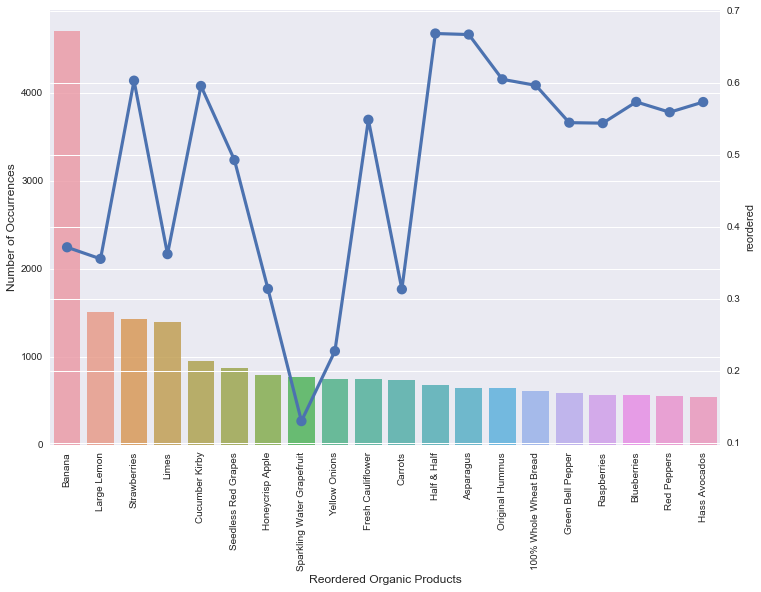

In [78]:
cnt_srs = product_counts['reordered'].head(20)
grouped_df = prev_orders.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
ax=sns.barplot(product_counts['product_name'].head(20), cnt_srs.values, alpha=0.8)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Reordered Organic Products', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax2= ax.twinx()
ax2= sns.pointplot(x=product_counts['product_name'].head(20), y=grouped_df.reordered)
plt.show()

The only thing of tremendous note is the fact that Bananas are 4x as popular as anything as even the second most popular products. Now let's look at what departments sell the most products. 

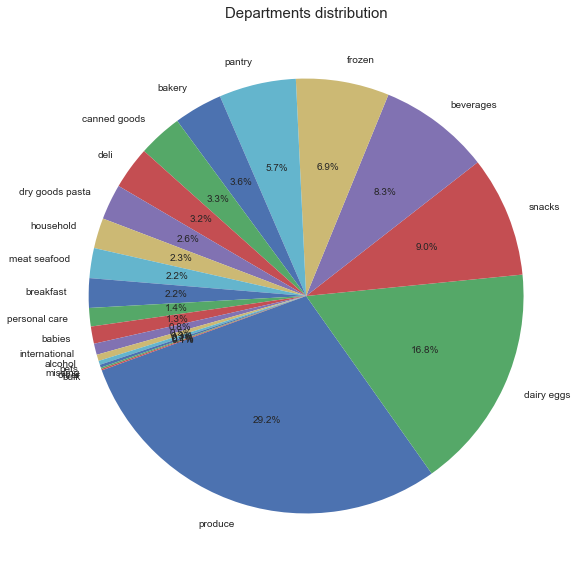

In [79]:
plt.figure(figsize=(10,10))
temp_series = prev_orders['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

The vast majority of goods purchased are related to food products, which isn't surprising because you constantly have to order fresh goods like produce and Dairy eggs as they go bad. 

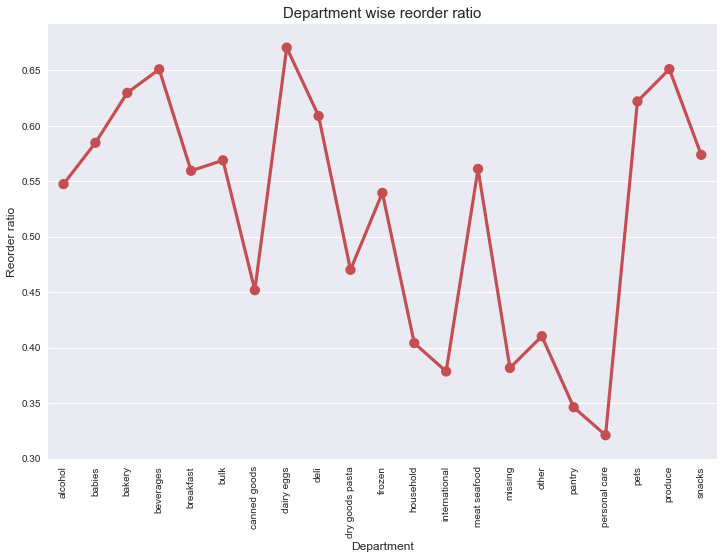

In [80]:
grouped_df = prev_orders.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

We see here that personal care products as well as international products are very unlikely to be reordered.

In [81]:
grouped_df = prev_orders.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

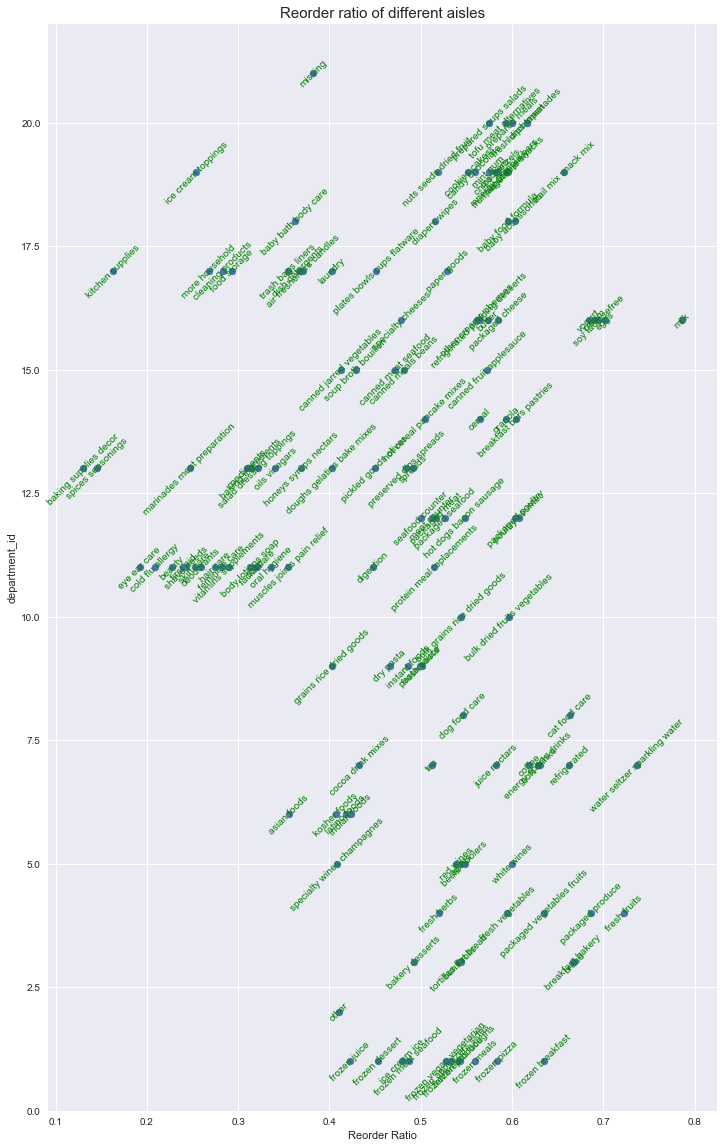

In [82]:
fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

Here's a fun though maybe not terribly illuminating graph about what departments of goods are reordered most often. 

In [83]:
prev_orders["add_to_cart_order_mod"] = prev_orders["add_to_cart_order"].copy()
prev_orders["add_to_cart_order_mod"].ix[prev_orders["add_to_cart_order_mod"]>70] = 70
grouped_df = prev_orders.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

E:\Conda2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
E:\Conda2\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


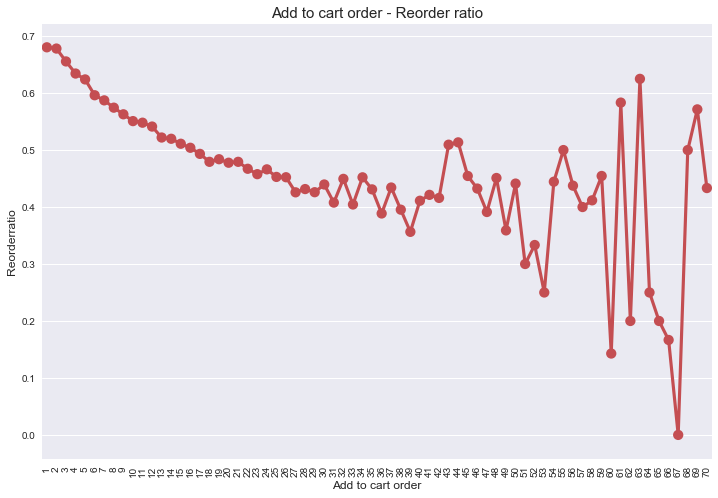

In [84]:
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorderratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()


Here we see that the later a product is ordered in the order chain, the less likely it is to be ordered. The only exception is at the far end where people just aren't ordering that many products. 

In [85]:
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,Organic,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order_mod
243639,1419982,8914,9,0,Chicken Breast,35,12,meat seafood,poultry counter,0,89138,prior,17,0,13,11.0,9
3214595,2125760,1244,38,1,Organic Orange Bell Pepper,83,4,produce,fresh vegetables,1,20554,prior,7,6,12,8.0,38
1876529,3368332,33401,9,0,Goat Cheese Crumbles,21,16,dairy eggs,packaged cheese,0,193112,prior,4,0,11,7.0,9
1092329,1991996,44142,13,0,Red Onion,83,4,produce,fresh vegetables,0,55248,prior,1,0,14,NaN,13
2698818,1238663,21174,6,0,I Heart Baby Kale,123,4,produce,packaged vegetables fruits,0,23643,prior,10,2,1,16.0,6


In [86]:
grouped_df = prev_orders.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()


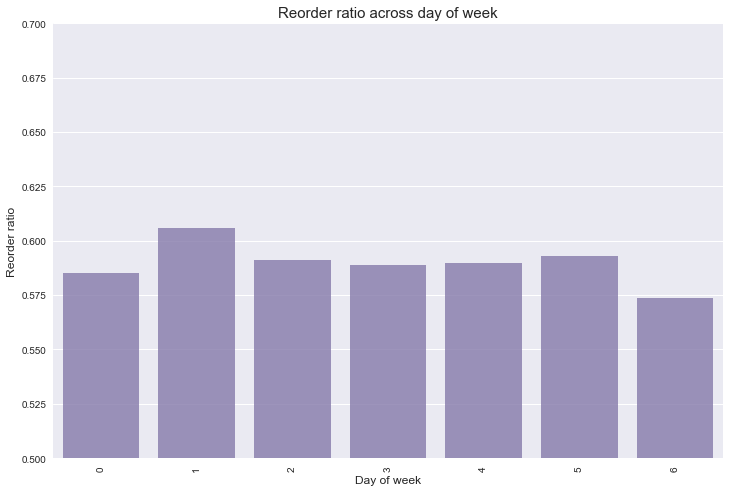

In [87]:
plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

In [88]:
grouped_df = prev_orders.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

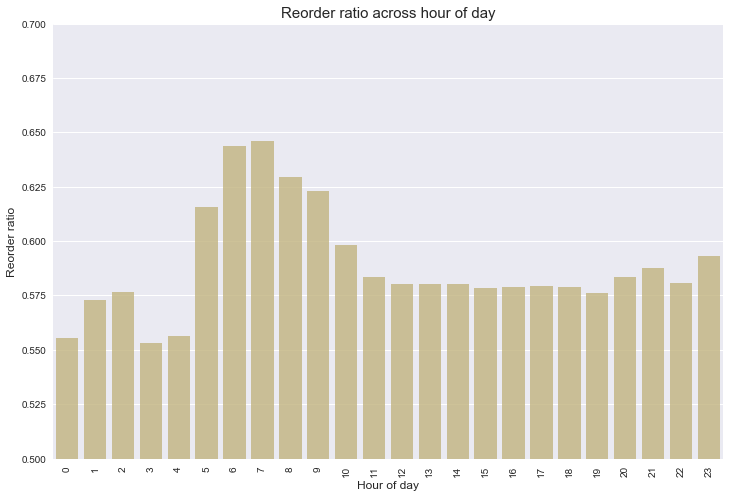

In [89]:
plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

The reorder ratio seems to be highest between 5 and 9 AM. People may be reordering at the beginning of the day, it may be beneficial to advertize morning products like coffee and toothpaste during these hours. 

Now that we've done our data exploration, we can work on predicting whether it is possible to predict whether a certain product will be reordered or not with machine learning. First, we select our variables.

In [34]:
prev_orders.shape

(324345, 17)

In [30]:
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,Organic,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,hour_of_week
243639,1419982,8914,9,0,Chicken Breast,35,12,meat seafood,poultry counter,0,89138,prior,17,0,13,11.0,13
3214595,2125760,1244,38,1,Organic Orange Bell Pepper,83,4,produce,fresh vegetables,1,20554,prior,7,6,12,8.0,156
1876529,3368332,33401,9,0,Goat Cheese Crumbles,21,16,dairy eggs,packaged cheese,0,193112,prior,4,0,11,7.0,11
1092329,1991996,44142,13,0,Red Onion,83,4,produce,fresh vegetables,0,55248,prior,1,0,14,999.0,14
2698818,1238663,21174,6,0,I Heart Baby Kale,123,4,produce,packaged vegetables fruits,0,23643,prior,10,2,1,16.0,49


In [27]:
prev_orders['hour_of_week']= prev_orders['order_dow']*24+prev_orders['order_hour_of_day']

In [29]:
prev_orders['days_since_prior_order']=prev_orders['days_since_prior_order'].fillna(999)

In [40]:
prev_orders['milk'] = np.where('milk' in prev_orders['product_name'], 'yes', 'no')

In [41]:
prev_orders['dairy']= np.where('dairy eggs' in prev_orders['department'], 'yes', 'no')

In [42]:
prev_orders['produce']=np.where('produce' in prev_orders['department'], 'yes', 'no')                                

In [43]:
prev_orders['pc']=np.where('personal' in prev_orders['department'], 'yes', 'no')                                

In [44]:
prev_orders['org_onion']=np.where('Organic Yellow Onion' in prev_orders['product_name'], 'yes', 'no')
prev_orders['sprk_wtr']=np.where('Sparkling Water' in prev_orders['product_name'], 'yes', 'no')

#Sparkling Water Organic Yellow Onion

In [45]:
df = prev_orders#[['reordered', 'product_id', 'aisle_id', 'department_id', 'add_to_cart_order', 'order_hour_of_day', 'days_since_prior_order', 'order_number', 'order_dow']]
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,Organic,...,order_dow,order_hour_of_day,days_since_prior_order,hour_of_week,milk,dairy,produce,pc,org_onion,sprk_wtr
243639,1419982,8914,9,0,Chicken Breast,35,12,meat seafood,poultry counter,0,...,0,13,11.0,13,no,no,no,no,no,no
3214595,2125760,1244,38,1,Organic Orange Bell Pepper,83,4,produce,fresh vegetables,1,...,6,12,8.0,156,no,no,no,no,no,no
1876529,3368332,33401,9,0,Goat Cheese Crumbles,21,16,dairy eggs,packaged cheese,0,...,0,11,7.0,11,no,no,no,no,no,no
1092329,1991996,44142,13,0,Red Onion,83,4,produce,fresh vegetables,0,...,0,14,999.0,14,no,no,no,no,no,no
2698818,1238663,21174,6,0,I Heart Baby Kale,123,4,produce,packaged vegetables fruits,0,...,2,1,16.0,49,no,no,no,no,no,no


In [46]:
y = df['reordered']
y.head()

243639     0
3214595    1
1876529    0
1092329    0
2698818    0
Name: reordered, dtype: int64

In [47]:
p_order = prev_orders#.sample(frac=0.1, random_state=1)
target = p_order['reordered']
p_order=p_order.drop('reordered', axis=1)

In [48]:
p_order[['product_id', 'user_id']]=p_order[['product_id', 'user_id']].astype('object')
p_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324345 entries, 243639 to 1390703
Data columns (total 22 columns):
order_id                  324345 non-null int64
product_id                324345 non-null object
add_to_cart_order         324345 non-null int64
product_name              324345 non-null object
aisle_id                  324345 non-null int64
department_id             324345 non-null int64
department                324345 non-null object
aisle                     324345 non-null object
Organic                   324345 non-null int32
user_id                   324345 non-null object
eval_set                  324345 non-null object
order_number              324345 non-null int64
order_dow                 324345 non-null int64
order_hour_of_day         324345 non-null int64
days_since_prior_order    324345 non-null float64
hour_of_week              324345 non-null int64
milk                      324345 non-null object
dairy                     324345 non-null object
produce  

For now, we're just gonna implement the slightly hunga bunga strategy of vtreat so that we can quickly develop our baseline model. and quickly begin to see if our  engineered features improves performance as well as guide our further decision making. 

In [49]:
import vtreat
plan = vtreat.BinomialOutcomeTreatment(outcome_target=True)
cross_frame = plan.fit_transform(p_order, target)
cross_frame.head()

,product_id,add_to_cart_order,department_id,Organic,order_number,order_dow,order_hour_of_day,days_since_prior_order,hour_of_week,product_name_logit_code,product_name_prevalence_code,department_logit_code,department_prevalence_code,department_lev_produce,department_lev_dairy eggs,aisle_logit_code,aisle_prevalence_code,aisle_lev_fresh fruits
0,8914.0,9.0,12.0,0.0,17.0,0.0,13.0,11.0,13.0,0.000000,0.000006,-0.051824,0.022279,0.0,0.0,0.026254,0.004097,0.0
1,1244.0,38.0,4.0,1.0,7.0,6.0,12.0,8.0,156.0,0.044381,0.000311,0.097356,0.292451,1.0,0.0,0.009248,0.105406,0.0
2,33401.0,9.0,16.0,0.0,4.0,0.0,11.0,7.0,11.0,-0.130815,0.000450,0.126810,0.167710,0.0,1.0,-0.009097,0.030329,0.0
3,44142.0,13.0,4.0,0.0,1.0,0.0,14.0,999.0,14.0,-0.050946,0.001378,0.099962,0.292451,1.0,0.0,0.011728,0.105406,0.0
4,21174.0,6.0,4.0,0.0,10.0,2.0,1.0,16.0,49.0,-0.123854,0.000370,0.098886,0.292451,1.0,0.0,0.075799,0.054624,0.0


In [50]:
plan.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,default_threshold,recommended
0,order_id,order_id,clean_copy,False,True,0.000040,9.820200e-01,12.0,0.020833,False
1,product_id,product_id,clean_copy,False,True,0.004771,6.585650e-03,12.0,0.020833,True
2,add_to_cart_order,add_to_cart_order,clean_copy,False,True,-0.134646,0.000000e+00,12.0,0.020833,True
3,aisle_id,aisle_id,clean_copy,False,True,0.003431,5.067354e-02,12.0,0.020833,False
4,department_id,department_id,clean_copy,False,True,-0.039393,1.480994e-111,12.0,0.020833,True
5,Organic,Organic,clean_copy,False,True,0.065459,7.892808e-305,12.0,0.020833,True
6,user_id,user_id,clean_copy,False,True,-0.003345,5.677102e-02,12.0,0.020833,False
7,order_number,order_number,clean_copy,False,True,0.307578,0.000000e+00,12.0,0.020833,True
8,order_dow,order_dow,clean_copy,False,True,-0.008858,4.536624e-07,12.0,0.020833,True
9,order_hour_of_day,order_hour_of_day,clean_copy,False,True,-0.022029,4.103279e-36,12.0,0.020833,True


In [51]:
X= cross_frame[plan.score_frame_.variable[plan.score_frame_.recommended == True].tolist()]

We simply grab the column vtreat reccommends for now and get started with our modeling. 

In [53]:
from sklearn.model_selection import train_test_split                                                                
X_train, X_test, y_train, y_test = train_test_split(X,target, test_size=.25)                                 

In [54]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(cv=3, class_weight='balanced', n_jobs=-1, max_iter = 250)
lr.fit(X_train, y_train)
y_train_pred = lr.predict_proba(X_train)[:,1]

In [55]:
y_test_pred = lr.predict_proba(X_test)[:,1]

In [56]:
print("Training Accuracy:", lr.score(X_train, y_train))
print("Training AUC", roc_auc_score(y_train, y_train_pred))
print("Training F1", f1_score(y_train, y_train_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred > 0.5))
print("-" * 40)
print("Test Accuracy:", lr.score(X_test, y_test))
print("Test AUC", roc_auc_score(y_test, y_test_pred))
print("Test F1", f1_score(y_test, y_test_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred > 0.5))
print()

Training Accuracy: 0.6990561461493559
Training AUC 0.7647457069341146
Training F1 0.7331318647268328
Confusion Matrix:
[[ 69495  30336]
 [ 42871 100556]]
----------------------------------------
Test Accuracy: 0.6997669170150579
Test AUC 0.7660755767902125
Test F1 0.7343148061245648
Confusion Matrix:
[[23099 10040]
 [14305 33643]]



AUC is about 2% better because of the new variables we've engineered. Although, interestingly, Accuracy appears to have dropped. 

In [58]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 5, criterion='entropy', random_state=42, class_weight='balanced')
rfc.fit(X_train, y_train)
y_train_pred = rfc.predict_proba(X_train)[:,1]

In [59]:
y_test_pred = rfc.predict_proba(X_test)[:,1]

In [60]:
print("Training Accuracy:", lr.score(X_train, y_train))
print("Training AUC", roc_auc_score(y_train, y_train_pred))
print("Training F1", f1_score(y_train, y_train_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred > 0.5))
print("-" * 40)
print("Test Accuracy:", lr.score(X_test, y_test))
print("Test AUC", roc_auc_score(y_test, y_test_pred))
print("Test F1", f1_score(y_test, y_test_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred > 0.5))
print()

Training Accuracy: 0.6990561461493559
Training AUC 0.9921529846134257
Training F1 0.970304970374109
Confusion Matrix:
[[ 94326   5505]
 [  3085 140342]]
----------------------------------------
Test Accuracy: 0.6997669170150579
Test AUC 0.7386483854496475
Test F1 0.7544650911058993
Confusion Matrix:
[[18951 14188]
 [10310 37638]]



Performance Largely unchanged, regardless. However, this is one of the most overfit models I think I may have ever seen. Not much change on accuracy or AUC but training AUC and Testing AUC suggests that that the model is heavily overfit. Cutting n_estimators may improve performance. Let's cut it down to 10 and see how it does. As they say, better features make better models. Let's see if we can engieer some feature interactions that can improve our models. 

In [61]:
sparse_cols = []
for i in X_train.columns.tolist():
    spars= X_train[i].dtype
    if 'Sparse' in str(spars):
        sparse_cols.append(spars)
        X_train[i]=X_train[i].astype('category')
        X_train[i]=X_train[i].astype('float')

E:\Conda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Conda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Vtreat has the tendency to convert sparse features to the sparse datatype, normally this is a good thing but some of our models don't really like it.The solution I came up with to turn 'em back was to convert to categorical and then back to floats. 

In [62]:
sparse_cols = []
for i in X_test.columns.tolist():
    spars= X_test[i].dtype
    if 'Sparse' in str(spars):
        sparse_cols.append(spars)
        X_test[i]=X_test[i].astype('category')
        X_test[i]=X_test[i].astype('float')

E:\Conda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Conda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [63]:
train = X_train.merge(y_train, left_index=True, right_index=True)
#train=train.sample(frac=0.05, replace=False, random_state=1)
test = X_test.merge(y_test, left_index=True, right_index=True )
#test=test.sample(frac=0.05, replace=False, random_state=1)

Basically what the next fifty ish lines are doing is a method I'd only heard about but wanted to try out. You subsample the data and subsample the features and then run a decision tree on that. Since you don't want to overfit, you prune that tree back and you look for useful nodes and branches where you see strong splits in the data .ie 90/10 or 80/20 with a large volume of datapoints. Once we have these nodes where these conditions are met, we can take the decision the leaf above the node made and turn that into it's own feature. Currently it only grabs the leaf above, but over the long term, I'd very much like to grab the entire branch as well as make this a generalizable thing if this technique comes out to be useful. 

The next several lines are me trying to understand how I want to design this process as well as working through how I want to navigate a node in a decision tree. 

In [64]:
import random
cols = X.columns.tolist()
k = int(np.round(len(cols)*.2))
k
u_cols = random.sample(cols, k)
u_cols

['department_prevalence_code',
 'department_lev_produce',
 'product_name_prevalence_code',
 'order_hour_of_day']

In [65]:
from sklearn.model_selection import train_test_split                                                                
X_train, X_test, y_train, y_test = train_test_split(X[u_cols],target, test_size=.25)                                 

In [66]:
from sklearn.tree import (DecisionTreeClassifier, export_graphviz)
from sklearn.model_selection import cross_val_score

from graphviz import Digraph

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

np.random.seed(42)

In [67]:
dt = DecisionTreeClassifier(criterion='gini', 
                            random_state=42, 
                            class_weight='balanced')
dt.fit(X_train,y_train)
y_train_pred = dt.predict_proba(X_train)[:,1]
y_test_pred = dt.predict_proba(X_test)[:,1]

In [68]:
dt.score(X_train, y_train)

0.6729028438941371

In [69]:
crossValScores = cross_val_score(dt, X_train, y_train, cv = 5)
print("Cross Validation Scores for unpruned tree are:\n", crossValScores)
print("Mean accuracy score is:\n", crossValScores.mean())
print("Std accuracy score is:\n", crossValScores.std())

Cross Validation Scores for unpruned tree are:
 [0.57874291 0.57765354 0.57621475 0.58046083 0.5773982 ]
Mean accuracy score is:
 0.5780940469416953
Std accuracy score is:
 0.0014305734901984325


In [70]:
crossValScores = cross_val_score(dt, X_test, y_test, cv = 5)
print("Cross Validation Scores for unpruned tree are:\n", crossValScores)
print("Mean accuracy score is:\n", crossValScores.mean())
print("Std accuracy score is:\n", crossValScores.std())

Cross Validation Scores for unpruned tree are:
 [0.56653101 0.55802195 0.5564531  0.56379108 0.5607079 ]
Mean accuracy score is:
 0.5611010106312408
Std accuracy score is:
 0.003686722462121442


In [71]:
print("Training Accuracy:", dt.score(X_train, y_train))
print("Training AUC", roc_auc_score(y_train, y_train_pred))
print("Training F1", f1_score(y_train, y_train_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred > 0.5))
print("-" * 40)
print("Test Accuracy:", dt.score(X_test, y_test))
print("Test AUC", roc_auc_score(y_test, y_test_pred))
print("Test F1", f1_score(y_test, y_test_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred > 0.5))
print()

Training Accuracy: 0.6729028438941371
Training AUC 0.7424306593289834
Training F1 0.7104275768703077
Confusion Matrix:
[[66083 33615]
 [45954 97606]]
----------------------------------------
Test Accuracy: 0.5759986187674966
Test AUC 0.5934393333718356
Test F1 0.6245837018595559
Confusion Matrix:
[[18106 15166]
 [19215 28600]]



In [72]:
import prune

In [73]:
model = DecisionTreeClassifier(criterion = "entropy")
model.fit(X_train, y_train)
pruner = prune.Pruner(model.tree_)
# pruner.pruneForCostComplexity(weights[maxWeighti]) 



In [74]:
n_nodes = dt.tree_.node_count
children_left = dt.tree_.children_left
children_right = dt.tree_.children_right
feature = dt.tree_.feature
threshold = dt.tree_.threshold


In [75]:
import prune 
tree = dt.tree_
print("Number of Nodes in Tree = ", tree.node_count)

pruner = prune.Pruner(dt.tree_)
nPrunes = len(pruner.pruneSequence) # This is the length of the pruning sequence.

Number of Nodes in Tree =  51025


In [76]:
# ax = plt.gca()
# prune.plotTreeOutput(ax, dt.tree_, [0,2], [2,1], edges = True)
# plt.title("Output for Unpruned Tree")
# plt.show()

In [77]:
import random
cols = X.columns.tolist()
k = int(np.round(len(cols)*.11))
k
u_cols = random.sample(cols, k)
u_cols

['order_number', 'department_id']

In [78]:
df_X = X.sample(frac=.1, random_state=42)
df_target = target.sample(frac=.1, random_state=42)

In [79]:
from sklearn.model_selection import train_test_split                                                                
X_train, X_test, y_train, y_test = train_test_split(df_X[u_cols],df_target, test_size=.25)                                 

In [80]:
weights = np.linspace(0.0, 6.0, 45)
nCrossVal = 20 
model = DecisionTreeClassifier(criterion = "entropy")

sizes, scores = prune.doCrossValidation(model, X_train[u_cols], y_train, nCrossVal, weights)

# Let's look at the statistics of the scores for different weights.

means = scores.mean(axis = 0)
stds = scores.std(axis = 0)

# Find the weight giving the best mean score.

maxWeighti = np.argmax(means)

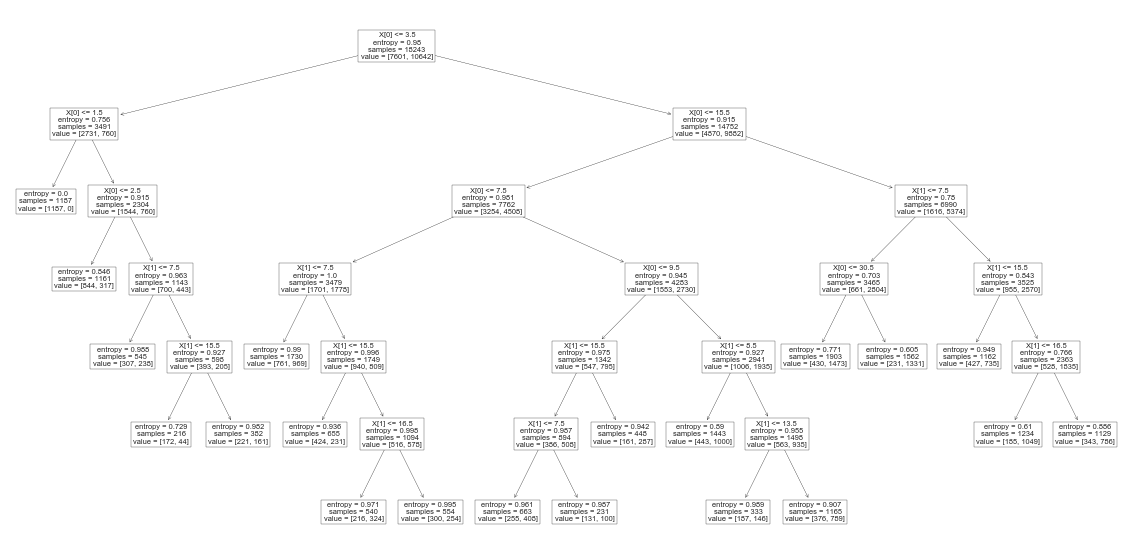

In [81]:
from sklearn import tree
plt.figure(figsize=(20,10))
_ = tree.plot_tree(model)
plt.show()


In [82]:
from scipy.stats import entropy
import numpy as np

In [86]:
feats = []
def tree_to_pseudo(tree, feature_names):

    '''
    Outputs a decision tree model as if/then pseudocode

    Parameters:
    -----------
    tree: decision tree model
        The decision tree to represent as pseudocode
    feature_names: list
        The feature names of the dataset used for building the decision tree
    '''

    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print (indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print (indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print (indent,"}")
            else:
                print (indent,"return " + str(value[node]))
                A = value[node][0][0]
                B = value[node][0][1]
                if A+B>500:
                    if A > (A+B)*.8:
                        print(indent, A)
                        print(features[node] + " <= " + str(threshold[node]))
                        feats.append({str(features[node] + " <= " + str(threshold[node])):value[node]})
                    if B>(A+B)*.8:
                        print(indent, B)
                        print(features[node] + " <= " + str(threshold[node]))
                        feats.append({str(features[node] + " <= " + str(threshold[node])):value[node]})
    recurse(left, right, threshold, features, 0)

In [2]:
# tree_to_pseudo(model, X_train.columns.tolist())

In [90]:
len(X)

324345

Now that we understand how to navigate the tree structure, we can try our hand at automating the process. 

In [4]:
weights = np.linspace(0.0, 6.0, 45)
nCrossVal = 20 
model = DecisionTreeClassifier(criterion = "entropy")
feats = []
for i in range(200):
    for j in [.1, .2, .3, .4]:
        print(i,j)
        k = int(np.round(len(cols)*j))
        u_cols = random.sample(cols, k)
        print( u_cols)
        df_X = X.sample(frac=.05, random_state=1)
        df_target = target.sample(frac=.05, random_state=1)
        X_train, X_test, y_train, y_test = train_test_split(df_X[u_cols],df_target, test_size=.25)  
        sizes, scores = prune.doCrossValidation(model, X_train[u_cols], y_train, nCrossVal, weights)
        means = scores.mean(axis = 0)
        maxWeighti = np.argmax(means)
        model = DecisionTreeClassifier(criterion = "entropy")
        model.fit(X_train, y_train)
        pruner = prune.Pruner(model.tree_)
        pruner.pruneForCostComplexity(weights[maxWeighti]) 
        tree_to_pseudo(model, X_train.columns.tolist())

In [93]:
feats[:5]

[{'aisle_logit_code <= 0.2389085665345192': array([[109., 613.]])},
 {'days_since_prior_order <= 11.5': array([[ 307., 1324.]])},
 {'aisle_prevalence_code <= 0.007046509068459272': array([[ 181., 1045.]])},
 {'days_since_prior_order <= 3.5': array([[146., 797.]])},
 {'department_logit_code <= 0.11291306093335152': array([[121., 657.]])}]

In [1]:
# feat_names = []
# for idx, i in enumerate(feats):
#     print(idx, i)
#     feat_names.append([*i])

Only problem is that we engineered like 700 features and it's unknown if these will even provide any value much less if it'll be anything significant. Plus, we should prune these down at some point as they will likely cover a lot of similar spaces. But for now let's see how the model performs in general. 

In [96]:
flat_list = [item for sublist in feat_names for item in sublist]
mini=flat_list[0].split(' ')
mini

['aisle_logit_code', '<=', '0.2389085665345192']

In [97]:
flat_list = [item for sublist in feat_names for item in sublist]
mini=flat_list[3].split(' ')
mini

['days_since_prior_order', '<=', '3.5']

In [98]:
flat_list
import csv
csvData = flat_list
with open('engineered_feats.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(csvData)
csvFile.close()

myfile = flat_list
with open('bruh_glap', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(flat_list)


In [3]:
# flat_list

In [100]:
for i in range(len(flat_list)):
    try:
        mini=(flat_list[i].split())
        bread = mini[0]+mini[1]+mini[2]
        red=df_X[mini[0]].apply(lambda x: x <= float(mini[2]))
        df_X[str(bread)]=red
    except: 
        continue

In [101]:
bread=mini[0]+mini[1]+mini[2]

In [103]:
red=df_X[mini[0]].apply(lambda x: x <= float(mini[2]))
df_X[str(bread)]=red

In [104]:
import vtreat
plan = vtreat.BinomialOutcomeTreatment(outcome_target=True)
cross_frame = plan.fit_transform(p_order, target)
cross_frame.head()

,product_id,add_to_cart_order,department_id,Organic,order_number,order_dow,order_hour_of_day,days_since_prior_order,hour_of_week,product_name_logit_code,product_name_prevalence_code,department_logit_code,department_prevalence_code,department_lev_produce,department_lev_dairy eggs,aisle_logit_code,aisle_prevalence_code,aisle_lev_fresh fruits
0,8914.0,9.0,12.0,0.0,17.0,0.0,13.0,11.0,13.0,2.220446e-16,0.000006,-0.047639,0.022279,0.0,0.0,0.031946,0.004097,0.0
1,1244.0,38.0,4.0,1.0,7.0,6.0,12.0,8.0,156.0,-5.701718e-03,0.000311,0.099775,0.292451,1.0,0.0,0.012226,0.105406,0.0
2,33401.0,9.0,16.0,0.0,4.0,0.0,11.0,7.0,11.0,-7.039987e-02,0.000450,0.131521,0.167710,0.0,1.0,-0.005122,0.030329,0.0
3,44142.0,13.0,4.0,0.0,1.0,0.0,14.0,999.0,14.0,-4.290467e-02,0.001378,0.095746,0.292451,1.0,0.0,0.003337,0.105406,0.0
4,21174.0,6.0,4.0,0.0,10.0,2.0,1.0,16.0,49.0,-1.186509e-01,0.000370,0.095746,0.292451,1.0,0.0,0.071111,0.054624,0.0


In [105]:
plan.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,default_threshold,recommended
0,order_id,order_id,clean_copy,False,True,0.000040,9.820200e-01,12.0,0.020833,False
1,product_id,product_id,clean_copy,False,True,0.004771,6.585650e-03,12.0,0.020833,True
2,add_to_cart_order,add_to_cart_order,clean_copy,False,True,-0.134646,0.000000e+00,12.0,0.020833,True
3,aisle_id,aisle_id,clean_copy,False,True,0.003431,5.067354e-02,12.0,0.020833,False
4,department_id,department_id,clean_copy,False,True,-0.039393,1.480994e-111,12.0,0.020833,True
5,Organic,Organic,clean_copy,False,True,0.065459,7.892808e-305,12.0,0.020833,True
6,user_id,user_id,clean_copy,False,True,-0.003345,5.677102e-02,12.0,0.020833,False
7,order_number,order_number,clean_copy,False,True,0.307578,0.000000e+00,12.0,0.020833,True
8,order_dow,order_dow,clean_copy,False,True,-0.008858,4.536624e-07,12.0,0.020833,True
9,order_hour_of_day,order_hour_of_day,clean_copy,False,True,-0.022029,4.103279e-36,12.0,0.020833,True


In [106]:
X= cross_frame[plan.score_frame_.variable[plan.score_frame_.recommended == True].tolist()]
X.head()

,product_id,add_to_cart_order,department_id,Organic,order_number,order_dow,order_hour_of_day,days_since_prior_order,hour_of_week,product_name_logit_code,product_name_prevalence_code,department_logit_code,department_prevalence_code,department_lev_produce,department_lev_dairy eggs,aisle_logit_code,aisle_prevalence_code,aisle_lev_fresh fruits
0,8914.0,9.0,12.0,0.0,17.0,0.0,13.0,11.0,13.0,2.220446e-16,0.000006,-0.047639,0.022279,0.0,0.0,0.031946,0.004097,0.0
1,1244.0,38.0,4.0,1.0,7.0,6.0,12.0,8.0,156.0,-5.701718e-03,0.000311,0.099775,0.292451,1.0,0.0,0.012226,0.105406,0.0
2,33401.0,9.0,16.0,0.0,4.0,0.0,11.0,7.0,11.0,-7.039987e-02,0.000450,0.131521,0.167710,0.0,1.0,-0.005122,0.030329,0.0
3,44142.0,13.0,4.0,0.0,1.0,0.0,14.0,999.0,14.0,-4.290467e-02,0.001378,0.095746,0.292451,1.0,0.0,0.003337,0.105406,0.0
4,21174.0,6.0,4.0,0.0,10.0,2.0,1.0,16.0,49.0,-1.186509e-01,0.000370,0.095746,0.292451,1.0,0.0,0.071111,0.054624,0.0


In [109]:
for i in range(len(flat_list)):
    try:
        mini=(flat_list[i].split())
        bread = mini[0]+mini[1]+mini[2]
        red=X[mini[0]].apply(lambda x: x <= float(mini[2]))
        X[str(bread)]=red
    except:
        continue

In [111]:
import vtreat
plan = vtreat.BinomialOutcomeTreatment(outcome_target=True)
cross_frame = plan.fit_transform(X, target)
cross_frame.head()

,add_to_cart_order,department_id,Organic,order_number,order_dow,order_hour_of_day,days_since_prior_order,hour_of_week,product_name_logit_code,product_name_prevalence_code,...,product_name_logit_code<=0.30914850533008575,aisle_logit_code<=0.005411494290456176,department_logit_code<=0.1276572346687317,product_name_logit_code<=0.33232468366622925,product_name_logit_code<=0.33279579877853394,product_name_logit_code<=0.354514941573143,department_logit_code<=0.09760117158293724,product_name_logit_code<=0.2445410117506981,aisle_prevalence_code<=0.015969107393175364,aisle_logit_code<=-0.09873981028795242
0,9.0,12.0,0.0,17.0,0.0,13.0,11.0,13.0,2.220446e-16,0.000006,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,38.0,4.0,1.0,7.0,6.0,12.0,8.0,156.0,-5.701718e-03,0.000311,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
2,9.0,16.0,0.0,4.0,0.0,11.0,7.0,11.0,-7.039987e-02,0.000450,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3,13.0,4.0,0.0,1.0,0.0,14.0,999.0,14.0,-4.290467e-02,0.001378,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,6.0,4.0,0.0,10.0,2.0,1.0,16.0,49.0,-1.186509e-01,0.000370,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [113]:
target=target.reset_index().drop('index', axis=1)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X,target, test_size=.25)                                 

In [115]:
sparse_cols = []
for i in X_train.columns.tolist():
    spars= X_train[i].dtype
    if 'bool' in str(spars):
        sparse_cols.append(spars)
        X_train[i]=X_train[i].astype('category')
        X_train[i]=X_train[i].astype('int')
    if 'Sparse' in str(spars):
        X_train[i]=X_train[i].astype('category')
        X_train[i]=X_train[i].astype('float')


E:\Conda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
E:\Conda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
E:\Conda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

In [116]:
sparse_cols = []
for i in X_test.columns.tolist():
    spars= X_test[i].dtype
    if 'bool' in str(spars):
        print(i)
        sparse_cols.append(spars)
        X_test[i]=X_test[i].astype('category')
        X_test[i]=X_test[i].astype('int')
    if 'Sparse' in str(spars):
        print(i)
        X_test[i]=X_train[i].astype('category')
        X_test[i]=X_train[i].astype('float')


department_lev_produce


E:\Conda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
E:\Conda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


department_lev_dairy eggs
aisle_lev_fresh fruits
aisle_logit_code<=0.2389085665345192


E:\Conda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
E:\Conda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


days_since_prior_order<=11.5
aisle_prevalence_code<=0.007046509068459272
days_since_prior_order<=3.5
department_logit_code<=0.11291306093335152
days_since_prior_order<=4.5
product_name_logit_code<=0.5232059061527252
department_lev_produce<=0.5
department_lev_produce<=0.5
aisle_logit_code<=0.1583058163523674
product_id<=204.0
product_name_logit_code<=0.17318595945835114
product_name_logit_code<=0.33560802042484283
days_since_prior_order<=25.5
order_number<=28.5
add_to_cart_order<=16.5
product_name_logit_code<=0.03350665234029293
product_name_logit_code<=0.3556680381298065
add_to_cart_order<=33.5
order_number<=55.5
aisle_logit_code<=0.22535786777734756
product_name_prevalence_code<=0.0007861998747102916
days_since_prior_order<=9.5
product_name_logit_code<=0.2503093481063843
days_since_prior_order<=8.5
days_since_prior_order<=21.5
order_hour_of_day<=21.5
add_to_cart_order<=9.5
order_number<=48.5
order_number<=15.5
days_since_prior_order<=0.5
order_number<=58.5
days_since_prior_order<=7.5


In [127]:
X_test

,product_id,add_to_cart_order,department_id,Organic,order_number,order_dow,order_hour_of_day,days_since_prior_order,hour_of_week,product_name_logit_code,...,aisle_logit_code<=0.005411494290456176,department_logit_code<=0.1276572346687317,product_name_logit_code<=0.33232468366622925,product_name_logit_code<=0.33279579877853394,hour_of_week<=12.5,product_name_logit_code<=0.354514941573143,department_logit_code<=0.09760117158293724,product_name_logit_code<=0.2445410117506981,aisle_prevalence_code<=0.015969107393175364,aisle_logit_code<=-0.09873981028795242
18273,47626.0,3.0,4.0,0.0,3.0,0.0,12.0,14.0,12.0,0.190728,...,0,1,1,1,1,1,0,1,0,0
234821,35951.0,7.0,16.0,1.0,8.0,0.0,13.0,20.0,13.0,0.238399,...,0,1,1,1,0,1,0,1,0,0
58933,14651.0,16.0,4.0,0.0,21.0,6.0,18.0,6.0,162.0,0.024224,...,0,1,1,1,0,1,0,1,0,0
136855,49683.0,3.0,4.0,0.0,5.0,4.0,15.0,9.0,111.0,0.124521,...,0,1,1,1,0,1,0,1,0,0
17671,46473.0,1.0,13.0,0.0,20.0,4.0,6.0,4.0,102.0,-1.315234,...,1,1,1,1,0,1,1,1,1,1
131742,47890.0,1.0,4.0,0.0,3.0,0.0,14.0,12.0,14.0,-0.144250,...,0,1,1,1,0,1,0,1,0,0
214586,30233.0,1.0,16.0,1.0,31.0,4.0,18.0,5.0,114.0,0.224379,...,0,1,1,1,0,1,0,1,1,0
56245,26604.0,6.0,4.0,1.0,10.0,2.0,15.0,1.0,63.0,0.104785,...,0,1,1,1,0,1,0,1,0,0
284177,46522.0,9.0,9.0,0.0,1.0,3.0,16.0,999.0,88.0,-0.288172,...,1,1,1,1,0,1,1,1,1,1
1360,21198.0,2.0,1.0,0.0,24.0,1.0,17.0,7.0,41.0,-0.334669,...,1,1,1,1,0,1,1,1,1,1


In [118]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_train)
y_train_pred = clf.predict_proba(X_train)[:,1]

E:\Conda2\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Conda2\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
E:\Conda2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\Conda2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
E:\Conda2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of ite

In [134]:
y_test_pred = clf.predict_proba(X_test.fillna(0))[:,1]

In [135]:
y_train_pred

array([0.48587958, 0.72880572, 0.94034553, ..., 0.85509981, 0.58277398,
       0.98790819])

In [136]:
y_train_pred.shape

(243258,)

In [137]:
X_train.shape

(243258, 361)

In [138]:
X_test.shape

(81087, 361)

In [139]:
y_test_pred.shape

(81087,)

In [142]:
print("Training Accuracy:", clf.score(X_train, y_train))
print("Training AUC", roc_auc_score(y_train,y_train_pred))
print("Training F1", f1_score(y_train, y_train_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred > 0.5))
print("-" * 40)
#print("Test Accuracy:", clf.score(X_test, y_test))
print("Test AUC", roc_auc_score(y_test, y_test_pred))
print("Test F1", f1_score(y_test, y_test_pred > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred > 0.5))


Training Accuracy: 0.7227264879263992
Training AUC 0.7872469662286739
Training F1 0.782793233482219
Confusion Matrix:
[[ 54269  45416]
 [ 22033 121540]]
----------------------------------------
Test AUC 0.7881413269524481
Test F1 0.7829016798179794
Confusion Matrix:
[[18233 15052]
 [ 7371 40431]]


We managed to make 2.5 % gains by adding in these features, however it's unclear this benefit is worth the extra computation. Feature Pruning is something we defenitely want to try in the future. 

In [143]:
cols =[]
for i in X_train.columns.tolist():
    if '<' in i:
        i=i.replace('<', 'grt')
    cols.append(i)

In [144]:
X_train_cols = X_train
X_train_cols.columns = cols
import xgboost as xgb
xg_clf = xgb.XGBClassifier(eval='auc')
xg_clf.fit(X_train_cols, y_train)

E:\Conda2\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Conda2\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval='auc', gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [145]:
X_test_cols = X_test
X_test_cols.columns=cols

In [146]:
xg_train_preds = xg_clf.predict(X_train)

In [147]:
xg_preds = xg_clf.predict(X_test)

In [148]:
print("Training Accuracy:", xg_clf.score(X_train_cols, y_train))
print("Training AUC", roc_auc_score(y_train,xg_train_preds))
print("Training F1", f1_score(y_train, xg_train_preds > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_train, xg_train_preds > 0.5))
print("-" * 40)
print("Test Accuracy:", xg_clf.score(X_test, y_test))
print("Test AUC", roc_auc_score(y_test, xg_preds))
print("Test F1", f1_score(y_test, xg_preds > 0.5))
print("Confusion Matrix:")
print(confusion_matrix(y_test, xg_preds > 0.5))


Training Accuracy: 0.7406169581267625
Training AUC 0.7147412016983488
Training F1 0.7961423517438573
Confusion Matrix:
[[ 56952  42733]
 [ 20364 123209]]
----------------------------------------
Test Accuracy: 0.7389717217309804
Test AUC 0.7128513802023101
Test F1 0.7950341835647744
Confusion Matrix:
[[18871 14414]
 [ 6752 41050]]


Little bit surprising that XGB is performing worse than Logistic Regression. This might just be because we ended up implementing so many decision tree nodes into our program as is. But, this isn't necessarily a bad thing. We've added a ton of features and having a simple model doing our calculations can make things come out much quicker. In the future, I'd like to implement some Recursive Feature Elimination as I think that there is a large large quantity of overlap our generated features have. Getting rid of the 'bad' features may even improve our predictive power. Also, currrently, we're only grabbing the last node in the decison tree, when it's supposed to be the entire branch that is the critical to that decision making. Therefore in the future, I want to also highly prioritize improving my 'node grabber' to the point that it is getting entire branches. It's interesting to me that we've added so many branches from decision trees and we're seemingly still not overfitting. It'd be interesting to see what woudl happpen with entire branches as well as seeing how it would perform if we weren't pruning the branches back. 
